# Fine-Tune Whisper For Multilingual ASR with 🤗 Transformers

In [1]:
from datasets import load_dataset, DatasetDict, Dataset, concatenate_datasets, IterableDataset, load_from_disk

ds = load_from_disk("/home/kd/Desktop/ds/Punjabi_ASR")
print(ds)
# train + valid as train_ds
train_ds = ds['train']
valid_ds = ds["test"]

print(train_ds)
print(valid_ds)
sum(train_ds['duration']) / 3600, sum(valid_ds['duration']) / 3600


Loading dataset from disk:   0%|          | 0/167 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/24 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'speaker_id', 'gender', 'duration', 'source', 'normalized_text'],
        num_rows: 113812
    })
    test: Dataset({
        features: ['audio', 'text', 'speaker_id', 'gender', 'duration', 'source', 'normalized_text'],
        num_rows: 16081
    })
})
Dataset({
    features: ['audio', 'text', 'speaker_id', 'gender', 'duration', 'source', 'normalized_text'],
    num_rows: 113812
})
Dataset({
    features: ['audio', 'text', 'speaker_id', 'gender', 'duration', 'source', 'normalized_text'],
    num_rows: 16081
})


(469.8450874682697, 38.31865094797178)

In [2]:
def remove_samples(data):
    durations = data['duration']
    texts = data['normalized_text']

    indexes = [i for i in range(len(data)) if durations[i] < 0.150]

    # # SPECIAL CONDITION FOR TESTING 
    # indexes = [i for i in range(len(data)) if (durations[i] < 0.150 or durations[i] > 10)]


    indexes2 = [i for i in range(len(data)) if len(texts[i]) == 0]
    
    indexes_to_remove = list(set(indexes + indexes2))
    x = data.select(indexes_to_remove)['normalized_text']
    remaining_index = [i for i in range(len(data)) if i not in indexes_to_remove]
    return data.select(remaining_index)


empty_audio_index = [15081]
valid_ds = valid_ds.select([i for i in range(len(valid_ds)) if i not in empty_audio_index])

train_empty_audio_indexes_with_inf_loss = [751, 1118, 10355, 11512, 15486, 15637, 17497, 17947, 19759, 20274, 21598, 22600, 24869, 25557, 26849, 29608, 32231, 33120, 34988, 35147, 35733, 40806, 42817, 44421, 45757, 46451, 46600, 49925, 51102, 51557, 55828, 61721, 62382, 62604, 63597, 64926, 65199, 65784, 66141, 66226, 70457, 71123, 72796, 73234, 73990, 74982, 75546, 76065, 79491, 82027, 88235, 88962, 90183, 90332, 90418, 92732, 94826, 95229, 95664, 95724, 95819, 98712, 99752, 100006, 100548, 101055, 101866, 102255, 104914, 109203, 109814, 111464, 112353, 112905, 113190]
train_ds = train_ds.select([i for i in range(len(train_ds)) if i not in train_empty_audio_indexes_with_inf_loss])

train_ds = remove_samples(train_ds)
print(train_ds)
valid_ds = remove_samples(valid_ds)
print(valid_ds)



Dataset({
    features: ['audio', 'text', 'speaker_id', 'gender', 'duration', 'source', 'normalized_text'],
    num_rows: 113731
})
Dataset({
    features: ['audio', 'text', 'speaker_id', 'gender', 'duration', 'source', 'normalized_text'],
    num_rows: 16080
})


(array([5.638e+03, 1.580e+03, 5.280e+02, 3.461e+03, 4.759e+03, 6.500e+01,
        2.700e+01, 1.400e+01, 6.000e+00, 2.000e+00]),
 array([ 1.63952381,  4.28357143,  6.92761905,  9.57166667, 12.21571429,
        14.8597619 , 17.50380952, 20.14785714, 22.79190476, 25.43595238,
        28.08      ]),
 <BarContainer object of 10 artists>)

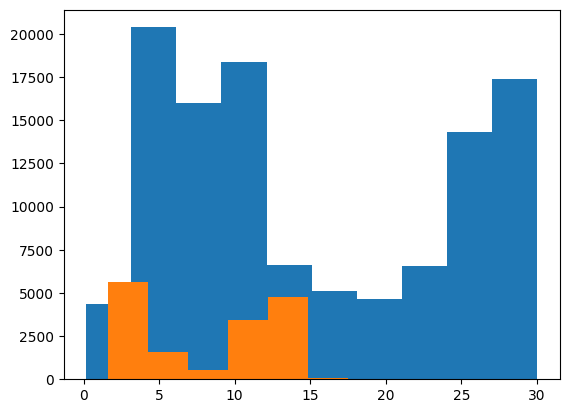

In [3]:
import pylab as plt
plt.hist(train_ds['duration'])
plt.hist(valid_ds['duration'])

We'll load the feature extractor from the pre-trained checkpoint with the default values:

In [4]:
model_name = 'openai/whisper-medium'

In [5]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x74f5ab8ce4b0>>
Traceback (most recent call last):
  File "/home/kd/anaconda3/envs/hf2/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


### Load WhisperTokenizer

The Whisper model outputs a sequence of _token ids_. The tokenizer maps each of these token ids to their corresponding text string. For Hindi, we can load the pre-trained tokenizer and use it for fine-tuning without any further modifications. We simply have to
specify the target language and the task. These arguments inform the
tokenizer to prefix the language and task tokens to the start of encoded
label sequences:

In [ ]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(model_name, language="Punjabi", task="transcribe")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Combine To Create A WhisperProcessor

To simplify using the feature extractor and tokenizer, we can _wrap_
both into a single `WhisperProcessor` class. This processor object
inherits from the `WhisperFeatureExtractor` and `WhisperProcessor`,
and can be used on the audio inputs and model predictions as required.
In doing so, we only need to keep track of two objects during training:
the `processor` and the `model`:

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(model_name, language="Punjabi", task="transcribe")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Prepare Data

Let's print the first example of the Common Voice dataset to see
what form the data is in:

In [ ]:
print(ds["train"][0])

{'audio': {'path': '844424931136176-442-f.m4a.wav', 'array': array([ 0.        ,  0.        ,  0.        , ..., -0.00144328,
       -0.00148821, -0.0013339 ]), 'sampling_rate': 16000}, 'text': 'ਇਨ੍ਹਾਂ ਦਿਨੀਂ ਸ਼ੋਅ ਦੀ ਸ਼ੂਟਿੰਗ ਚੱਲ ਰਹੀ ਹੈ ਅਤੇ ਸੈੱਟ ਤੋਂ ਲਾਰਾ ਦੱਤਾ ਹਾਲ ਹੀ ਵਿਚ ਜਾਰੀ ਹੋਏ ਹੁਕਮਨਾਮੇ ਜਿਸ ਦੇ ਵਿਚ ਮੌਜੂਦਾ ਸਕੱਤਰ ਸ ਇਸ ਲਈ ਵਰਤੇ ਗਏ ਫਾਊਂਡੇਸ਼ਨਾਂ ਦੀਆਂ ਕਿਸਮਾਂ ਬਹੁਤ ਦਿਲਚਸਪ ਹਨ ਆਪਣੇ ਹੱਥਾਂ ਨੂੰ ਸ਼ੀਸ਼ੇ ਨੂੰ ਬੱਤੀਆਂ ਜਾਂ ਦੰਦਾਂ ਵਿੱਚ ਕੰਮ ਕਰਨ ਲਈ ਵਰਤੋ ਪ੍ਰਕਾਸ਼ ਸਿੰਘ ਬਾਦਲ ਅਤੇ ਅਕਾਲੀ ਦਲ ਦੇ ਪ੍ਰਧਾਨ ਅਤੇ ਉਪ ਮੁੱਖ ਮੰਤਰੀ ਸ', 'speaker_id': '442', 'gender': 'f', 'duration': 24.2184126984127, 'source': 'IndicSuperb_pa_ASR__train', 'normalized_text': 'ਇਨ੍ਹਾਂ ਦਿਨੀਂ ਸ਼ੋਅ ਦੀ ਸ਼ੂਟਿੰਗ ਚੱਲ ਰਹੀ ਹੈ ਅਤੇ ਸੈੱਟ ਤੋਂ ਲਾਰਾ ਦੱਤਾ ਹਾਲ ਹੀ ਵਿਚ ਜਾਰੀ ਹੋਏ ਹੁਕਮਨਾਮੇ ਜਿਸ ਦੇ ਵਿਚ ਮੌਜੂਦਾ ਸਕੱਤਰ ਸ ਇਸ ਲਈ ਵਰਤੇ ਗਏ ਫਾਊਂਡੇਸ਼ਨਾਂ ਦੀਆਂ ਕਿਸਮਾਂ ਬਹੁਤ ਦਿਲਚਸਪ ਹਨ ਆਪਣੇ ਹੱਥਾਂ ਨੂੰ ਸ਼ੀਸ਼ੇ ਨੂੰ ਬੱਤੀਆਂ ਜਾਂ ਦੰਦਾਂ ਵਿੱਚ ਕੰਮ ਕਰਨ ਲਈ ਵਰਤੋ ਪ੍ਰਕਾਸ਼ ਸਿੰਘ ਬਾਦਲ ਅਤੇ ਅਕਾਲੀ ਦਲ ਦੇ ਪ੍ਰਧਾਨ ਅਤੇ ਉਪ ਮੁੱਖ ਮੰਤਰੀ ਸ'}


In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["normalized_text"]).input_ids
    return batch

We can apply the data preparation function to all of our training examples using dataset's `.map` method. The argument `num_proc` specifies how many CPU cores to use. Setting `num_proc` > 1 will enable multiprocessing. If the `.map` method hangs with multiprocessing, set `num_proc=1` and process the dataset sequentially.

In [ ]:
ds = DatasetDict({"train": train_ds, "valid": valid_ds})
ds

DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'speaker_id', 'gender', 'duration', 'source', 'normalized_text'],
        num_rows: 113731
    })
    valid: Dataset({
        features: ['audio', 'text', 'speaker_id', 'gender', 'duration', 'source', 'normalized_text'],
        num_rows: 16080
    })
})

In [ ]:

ds = ds.map(prepare_dataset, remove_columns=ds.column_names["train"], num_proc=1, cache_file_names={'train': "/mnt/sea/tmp/train-mid.arrow", 'valid': "/mnt/sea/tmp/valid-mid.arrow"})

## Training and Evaluation

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(model_name)

We can disable the automatic language detection task performed during inference, and force the model to generate in Hindi. To do so, we set the [langauge](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperForConditionalGeneration.generate.language)
and [task](https://huggingface.co/docs/transformers/en/model_doc/whisper#transformers.WhisperForConditionalGeneration.generate.task)
arguments to the generation config. We'll also set any [`forced_decoder_ids`](https://huggingface.co/docs/transformers/main_classes/text_generation#transformers.generation_utils.GenerationMixin.generate.forced_decoder_ids)
to None, since this was the legacy way of setting the language and
task arguments:

In [ ]:
model.generation_config.language = "punjabi"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None

### Define a Data Collator

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

Let's initialise the data collator we've just defined:

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

### Evaluation Metrics

We'll use the word error rate (WER) metric, the 'de-facto' metric for assessing
ASR systems. For more information, refer to the WER [docs](https://huggingface.co/metrics/wer). We'll load the WER metric from 🤗 Evaluate:

In [ ]:
import evaluate

metric = evaluate.load("wer")

We then simply have to define a function that takes our model
predictions and returns the WER metric. This function, called
`compute_metrics`, first replaces `-100` with the `pad_token_id`
in the `label_ids` (undoing the step we applied in the
data collator to ignore padded tokens correctly in the loss).
It then decodes the predicted and label ids to strings. Finally,
it computes the WER between the predictions and reference labels:

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Define the Training Configuration

In the final step, we define all the parameters related to training. For more detail on the training arguments, refer to the Seq2SeqTrainingArguments [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments).

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-medium-pa",  # change to a repo name of your choice
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    gradient_accumulation_steps=8,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    num_train_epochs=12,
    warmup_steps=1000,
    # max_steps=4000,
    gradient_checkpointing=True,
    bf16=True,
    evaluation_strategy="steps",
    predict_with_generate=True,
    # generation_max_length=225,
    save_steps=300,
    eval_steps=300,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
)

**Note**: if one does not want to upload the model checkpoints to the Hub,
set `push_to_hub=False`.

We can forward the training arguments to the 🤗 Trainer along with our model,
dataset, data collator and `compute_metrics` function:

In [ ]:
print(ds)

train_labels_lengths = ds['train']['labels']
valid_labels_lengths = ds['valid']['labels']

train_labels_lengths = [len(i) for i in train_labels_lengths]
valid_labels_lengths = [len(i) for i in valid_labels_lengths]

train_selected_indexes = [i for i in range(len(train_labels_lengths)) if train_labels_lengths[i] < 448]
valid_selected_indexes = [i for i in range(len(valid_labels_lengths)) if valid_labels_lengths[i] < 448]

train_ds = ds['train'].select(train_selected_indexes)
valid_ds = ds['valid'].select(valid_selected_indexes)

ds = DatasetDict({"train": train_ds, "valid": valid_ds})
print(ds)

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 113731
    })
    valid: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 16080
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 73310
    })
    valid: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 16074
    })
})


In [ ]:
from transformers import Seq2SeqTrainer
# Test this with IterableDataset
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=ds['train'],
    eval_dataset=ds['valid'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

/home/kd/anaconda3/envs/hf2/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


We'll save the processor object once before starting training. Since the processor is not trainable, it won't change over the course of training:

In [ ]:
processor.save_pretrained(training_args.output_dir)

[]

In [ ]:
ds['train']

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 73310
})

In [ ]:
len(ds['train'][34]['input_features'][4])

3000

In [ ]:
labels = ds['train']['labels']
len_of_labels = [len(label) for label in labels]
max_len = max(len_of_labels)
min_len = min(len_of_labels)
print(max_len, min_len)

447 9


In [ ]:
# count len_of_labels greater than equals to 448
count = 0
for i in len_of_labels:
    if i >= 448:
        count += 1

print(count)

0


In [ ]:
113731-40421

73310

### Training

In [ ]:
# import gc
# gc.collect()


# # clear gpu ram
# torch.cuda.empty_cache()


In [ ]:
trainer.train()

  0%|          | 0/10992 [00:00<?, ?it/s]

/home/kd/anaconda3/envs/hf2/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


{'loss': 1.1117, 'grad_norm': 9.816136360168457, 'learning_rate': 2.5000000000000004e-07, 'epoch': 0.03}
{'loss': 0.9831, 'grad_norm': 8.426244735717773, 'learning_rate': 5.000000000000001e-07, 'epoch': 0.05}
{'loss': 0.733, 'grad_norm': 5.270755767822266, 'learning_rate': 7.5e-07, 'epoch': 0.08}
{'loss': 0.5062, 'grad_norm': 2.5098249912261963, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.11}
{'loss': 0.3632, 'grad_norm': 1.9597983360290527, 'learning_rate': 1.25e-06, 'epoch': 0.14}
{'loss': 0.2786, 'grad_norm': 1.7050025463104248, 'learning_rate': 1.5e-06, 'epoch': 0.16}
{'loss': 0.2297, 'grad_norm': 3.410609245300293, 'learning_rate': 1.75e-06, 'epoch': 0.19}
{'loss': 0.1977, 'grad_norm': 2.1795804500579834, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.22}
{'loss': 0.176, 'grad_norm': 1.3645052909851074, 'learning_rate': 2.25e-06, 'epoch': 0.25}
{'loss': 0.1609, 'grad_norm': 1.2841603755950928, 'learning_rate': 2.5e-06, 'epoch': 0.27}
{'loss': 0.1485, 'grad_norm': 1.58

  0%|          | 0/1608 [00:00<?, ?it/s]

Our best WER is 32.0% - not bad for 8h of training data! We can make our model more accessible on the Hub with appropriate tags and README information.
You can change these values to match your dataset, language and model
name accordingly:

In [ ]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_11_0",
    "dataset": "Common Voice 11.0",  # a 'pretty' name for the training dataset
    "dataset_args": "config: hi, split: test",
    "language": "hi",
    "model_name": "Whisper Small Hi - Sanchit Gandhi",  # a 'pretty' name for our model
    "finetuned_from": "openai/whisper-small",
    "tasks": "automatic-speech-recognition",
}

The training results can now be uploaded to the Hub. To do so, execute the `push_to_hub` command and save the preprocessor object we created:

In [ ]:
trainer.push_to_hub(**kwargs)

## Building a Demo

Now that we've fine-tuned our model we can build a demo to show
off its ASR capabilities! We'll make use of 🤗 Transformers
`pipeline`, which will take care of the entire ASR pipeline,
right from pre-processing the audio inputs to decoding the
model predictions.

Running the example below will generate a Gradio demo where we
can record speech through the microphone of our computer and input it to
our fine-tuned Whisper model to transcribe the corresponding text:

In [ ]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="sanchit-gandhi/whisper-small-hi")  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

iface = gr.Interface(
    fn=transcribe,
    inputs=gr.Audio(source="microphone", type="filepath"),
    outputs="text",
    title="Whisper Small Hindi",
    description="Realtime demo for Hindi speech recognition using a fine-tuned Whisper small model.",
)

iface.launch()

## Closing Remarks

In this blog, we covered a step-by-step guide on fine-tuning Whisper for multilingual ASR
using 🤗 Datasets, Transformers and the Hugging Face Hub. For more details on the Whisper model, the Common Voice dataset and the theory behind fine-tuning, refere to the accompanying [blog post](https://huggingface.co/blog/fine-tune-whisper). If you're interested in fine-tuning other
Transformers models, both for English and multilingual ASR, be sure to check out the
examples scripts at [examples/pytorch/speech-recognition](https://github.com/huggingface/transformers/tree/main/examples/pytorch/speech-recognition).